# Análisis de Ciberseguridad con Datos Reales

Este cuaderno carga y analiza dos datasets reales para calcular KPIs (MTTR/MTTD), modelar detección de phishing mediante heurísticas simples y generar visualizaciones.

Antes de ejecutar:
- Descarga desde Kaggle y coloca en este mismo directorio (`notebooks/`):
  - `Global_Cybersecurity_Threats_2015-2024.csv`
  - `CEAS_08.csv`

Ejecuta las celdas en orden. Si algún archivo no existe, se mostrará un mensaje claro de ayuda.


## Guía rápida de celdas

- Importaciones y configuración: instala y carga librerías necesarias; fija estilo de gráficos y muestra versión de Python y ruta de trabajo.
- Utilidad find_csv: función auxiliar para localizar automáticamente los CSV en `notebooks/`, `data/` o la raíz.
- Carga y limpieza de Amenazas: lee `Global_Cybersecurity_Threats_2015-2024.csv`, renombra columnas, convierte métricas a numérico y elimina nulos críticos.
- Carga y limpieza de Phishing: lee `CEAS_08.csv`, renombra columnas de texto/etiqueta y elimina filas sin contenido útil.
- KPIs MTTR/MTTD: calcula promedios globales y segmenta por año/tipo si las columnas existen.
- Modelado de Phishing: aplica una heurística por palabras clave sobre asunto/cuerpo, estima verdaderos positivos y tasa de detección.
- Visualizaciones: genera comparativa de métricas, evolución anual, boxplot por tipo, heatmap por industria/año y nube de palabras (si hay datos y no está en modo rápido).


In [1]:
# UTILIDAD: Mostrar tablas con títulos
from typing import Optional
from IPython.display import display, Markdown

def show_table(df, title: str, note: Optional[str] = None):
    if title:
        display(Markdown(f"### {title}"))
    if note:
        display(Markdown(f"_Nota:_ {note}"))
    try:
        styled = df.style.set_table_styles([
            {"selector": "th", "props": "text-align:center; background:#f5f5f5;"}
        ]).set_properties(**{"text-align": "left"})
        display(styled)
    except Exception:
        display(df)

def show_series(s, title: str, note: Optional[str] = None):
    if title:
        display(Markdown(f"### {title}"))
    if note:
        display(Markdown(f"_Nota:_ {note}"))
    display(s.to_frame(name="value"))


In [2]:
# -*- coding: utf-8 -*-
# =============================================================================
# PROMPT PARA JUPYTER NOTEBOOK: ANÁLISIS DE CIBERSEGURIDAD CON DATOS REALES
# Basado en la tesis: "Programa en Python para el Registro y Documentación 
# de Incidentes de Ciberseguridad en Empresas Medianas"
# =============================================================================

# PASO 1: CONFIGURACIÓN E IMPORTACIÓN DE BIBLIOTECAS
import sys
import os
import subprocess
import importlib

# Función auxiliar para instalar si falta
def ensure_package(pkg_name: str, import_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg_name)
    except ModuleNotFoundError:
        print(f"Instalando paquete faltante: {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name, "--quiet"]) 
        return importlib.import_module(import_name or pkg_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sns = ensure_package("seaborn")
WordCloud = ensure_package("wordcloud", "wordcloud").WordCloud

print("Bibliotecas importadas correctamente.")
print(f"Versión de Python: {sys.version}")
print(f"Directorio de trabajo: {os.getcwd()}")

# Ajustes estéticos de gráficos
sns.set(style="whitegrid", palette="muted", context="notebook")


Bibliotecas importadas correctamente.
Versión de Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
Directorio de trabajo: c:\Users\INMORTAL\OneDrive\Documentos\python\notebooks


In [3]:
# PASO 2.1: CARGA Y PREPARACIÓN - Amenazas Globales
print("\n--- Cargando el conjunto de datos de Amenazas Globales ---")

from typing import List

threats_path = 'Global_Cybersecurity_Threats_2015-2024.csv'
threats_df = pd.DataFrame()

if not os.path.exists(threats_path):
    print("Error: 'Global_Cybersecurity_Threats_2015-2024.csv' no encontrado.")
    print("Por favor, asegúrate de colocar el archivo en el mismo directorio que este cuaderno.")
else:
    threats_df = pd.read_csv(threats_path)
    print("Conjunto de datos 'Global_Cybersecurity_Threats_2015-2024.csv' cargado exitosamente.")

if not threats_df.empty:
    print("\n--- Información Inicial del DataFrame de Amenazas ---")
    show_table(threats_df.head(), title="Vista previa de amenazas (5 filas)")

    # Renombrar columnas esperadas si existen
    rename_map = {
        'Response Time (Hours)': 'Response_Time_Hours',
        'Incident Resolution Time (in Hours)': 'Resolution_Time_Hours',
        'Threat Type': 'Threat_Type',
        'Affected Industry': 'Affected_Industry'
    }
    existing_renames = {k: v for k, v in rename_map.items() if k in threats_df.columns}
    threats_df.rename(columns=existing_renames, inplace=True)

    # Columnas críticas para métricas
    expected_numeric_cols: List[str] = []
    if 'Response_Time_Hours' in threats_df.columns:
        expected_numeric_cols.append('Response_Time_Hours')
    if 'Resolution_Time_Hours' in threats_df.columns:
        expected_numeric_cols.append('Resolution_Time_Hours')

    # Eliminar filas con nulos en columnas críticas
    initial_rows = len(threats_df)
    if expected_numeric_cols:
        threats_df.dropna(subset=expected_numeric_cols, inplace=True)
        print(f"Se eliminaron {initial_rows - len(threats_df)} filas con valores de tiempo nulos.")

    # Convertir sólo columnas numéricas esperadas
    for col in expected_numeric_cols:
        threats_df[col] = pd.to_numeric(threats_df[col], errors='coerce')
    # Volver a eliminar nulos si los hubiese tras la conversión
    if expected_numeric_cols:
        before_re_drop = len(threats_df)
        threats_df.dropna(subset=expected_numeric_cols, inplace=True)
        print(f"Filas eliminadas tras coerción numérica: {before_re_drop - len(threats_df)}")

    # Asegurar tipos de apoyo
    if 'Year' in threats_df.columns:
        threats_df['Year'] = pd.to_numeric(threats_df['Year'], errors='coerce').astype('Int64')

    print("\nLimpieza de Amenazas completada. Tipos de datos verificados.")
    show_table(threats_df.dtypes.to_frame(name='dtype'), title="Tipos de datos de amenazas")



--- Cargando el conjunto de datos de Amenazas Globales ---
Error: 'Global_Cybersecurity_Threats_2015-2024.csv' no encontrado.
Por favor, asegúrate de colocar el archivo en el mismo directorio que este cuaderno.


In [4]:
# PASO 2.2: CARGA Y PREPARACIÓN - Phishing (CEAS_08)
print("\n--- Cargando el conjunto de datos de Phishing ---")

phishing_path = 'CEAS_08.csv'
phishing_df = pd.DataFrame()

if not os.path.exists(phishing_path):
    print("Error: 'CEAS_08.csv' no encontrado.")
    print("Por favor, asegúrate de colocar el archivo en el mismo directorio que este cuaderno.")
else:
    phishing_df = pd.read_csv(phishing_path)
    print("Conjunto de datos 'CEAS_08.csv' cargado exitosamente.")

if not phishing_df.empty:
    # Renombrar columnas si existen
    rename_map = {
        'date': 'DateTime',
        'body': 'Body',
        'subject': 'Subject',
        'label': 'Label'
    }
    existing_renames = {k: v for k, v in rename_map.items() if k in phishing_df.columns}
    phishing_df.rename(columns=existing_renames, inplace=True)

    # Eliminar filas sin texto útil
    subset_cols = [c for c in ['Body', 'Subject'] if c in phishing_df.columns]
    if subset_cols:
        before = len(phishing_df)
        phishing_df.dropna(subset=subset_cols, inplace=True)
        print(f"Filas sin texto eliminadas: {before - len(phishing_df)}")

    # Asegurar tipos de texto en campos relevantes
    for c in ['Body', 'Subject']:
        if c in phishing_df.columns:
            phishing_df[c] = phishing_df[c].astype(str)

    # Normalizar etiqueta
    if 'Label' in phishing_df.columns:
        phishing_df['Label'] = phishing_df['Label'].astype(str)

    print("\nLimpieza del conjunto de datos de phishing completada.")
    show_table(phishing_df.head(), title="Vista previa de phishing (5 filas)")



--- Cargando el conjunto de datos de Phishing ---
Conjunto de datos 'CEAS_08.csv' cargado exitosamente.
Filas sin texto eliminadas: 28

Limpieza del conjunto de datos de phishing completada.


### Vista previa de phishing (5 filas)

In [5]:
# PASO 3.1: KPIs MTTR y MTTD
if not threats_df.empty:
    # Determinar columnas disponibles
    mttr_col = 'Resolution_Time_Hours' if 'Resolution_Time_Hours' in threats_df.columns else None
    mttd_col = 'Response_Time_Hours' if 'Response_Time_Hours' in threats_df.columns else None

    print("\n--- ANÁLISIS DE MÉTRICAS DE RESPUESTA ---")
    if mttr_col:
        overall_mttr = threats_df[mttr_col].mean()
        show_series(pd.Series([overall_mttr], index=['MTTR (horas)']), title="MTTR General")
    else:
        overall_mttr = np.nan
        print("MTTR no disponible (columna no encontrada).")

    if mttd_col:
        overall_mttd = threats_df[mttd_col].mean()
        show_series(pd.Series([overall_mttd], index=['MTTD (horas)']), title="MTTD General")
    else:
        overall_mttd = np.nan
        print("MTTD no disponible (columna no encontrada).")

    # Segmentación por tipo de amenaza (si existe)
    if 'Threat_Type' in threats_df.columns:
        mttr_by_threat = threats_df.groupby('Threat_Type')[mttr_col].mean().sort_values(ascending=False) if mttr_col else None
        mttd_by_threat = threats_df.groupby('Threat_Type')[mttd_col].mean().sort_values(ascending=False) if mttd_col else None
        if mttr_by_threat is not None:
            show_series(mttr_by_threat.head(), title="MTTR por Tipo de Amenaza (Top 5)")
        if mttd_by_threat is not None:
            show_series(mttd_by_threat.head(), title="MTTD por Tipo de Amenaza (Top 5)")

    # Evolución por año (si existe)
    if 'Year' in threats_df.columns:
        mttr_by_year = threats_df.groupby('Year')[mttr_col].mean() if mttr_col else None
        mttd_by_year = threats_df.groupby('Year')[mttd_col].mean() if mttd_col else None
        if mttr_by_year is not None:
            show_series(mttr_by_year, title="Evolución del MTTR por Año")
else:
    print("\nADVERTENCIA: No se pueden calcular MTTR/MTTD: DataFrame de amenazas vacío.")
    overall_mttr, overall_mttd = np.nan, np.nan
    mttr_by_year, mttd_by_year = None, None



ADVERTENCIA: No se pueden calcular MTTR/MTTD: DataFrame de amenazas vacío.


In [6]:
# PASO 3.2: Modelado de Detección de Phishing (Heurístico)
if not phishing_df.empty:
    print("\n--- MODELADO DE DETECCIÓN DE PHISHING ---")

    phishing_keywords = [
        'verify', 'account', 'password', 'urgent', 'suspend', 'confirm', 'login',
        'secure', 'bank', 'credit card', 'invoice', 'payment', 'winner', 'update'
    ]

    def detect_keywords(text: str) -> int:
        if not isinstance(text, str):
            return 0
        lower_text = text.lower()
        for keyword in phishing_keywords:
            if keyword in lower_text:
                return 1
        return 0

    text_source = None
    if all(c in phishing_df.columns for c in ['Subject', 'Body']):
        text_source = phishing_df['Subject'].fillna('') + ' ' + phishing_df['Body'].fillna('')
    elif 'Body' in phishing_df.columns:
        text_source = phishing_df['Body'].fillna('')
    elif 'Subject' in phishing_df.columns:
        text_source = phishing_df['Subject'].fillna('')

    if text_source is not None:
        phishing_df['Predicted_Phishing'] = text_source.apply(detect_keywords)

        if 'Label' in phishing_df.columns:
            phishing_df['Actual_Phishing'] = phishing_df['Label'].str.lower().isin(['1', 'spam', 'phishing']).astype(int)
        else:
            phishing_df['Actual_Phishing'] = 0

        true_positives = int(((phishing_df['Predicted_Phishing'] == 1) & (phishing_df['Actual_Phishing'] == 1)).sum())
        actual_phishing_count = int((phishing_df['Actual_Phishing'] == 1).sum())

        if actual_phishing_count > 0:
            detection_rate = (true_positives / actual_phishing_count) * 100
            show_table(
                pd.DataFrame({
                    'Métrica': ['Total phishing real', 'Verdaderos positivos', 'Tasa detección (%)'],
                    'Valor': [actual_phishing_count, true_positives, round(detection_rate, 2)]
                }),
                title="Resultados del modelo heurístico de phishing"
            )
        else:
            print("No se encontraron correos de phishing en el dataset para calcular la tasa de detección.")
            detection_rate = np.nan
            actual_phishing_count = 0
    else:
        print("Columnas de texto no disponibles para modelar detección.")
        detection_rate = np.nan
        actual_phishing_count = 0
else:
    print("\nADVERTENCIA: No se puede realizar el modelado de phishing: DataFrame vacío.")
    detection_rate = np.nan
    actual_phishing_count = 0



--- MODELADO DE DETECCIÓN DE PHISHING ---


### Resultados del modelo heurístico de phishing

,Métrica,Valor
0,Total phishing real,21829.000000
1,Verdaderos positivos,1921.000000
2,Tasa detección (%),8.800000



--- GENERANDO VISUALIZACIONES ---


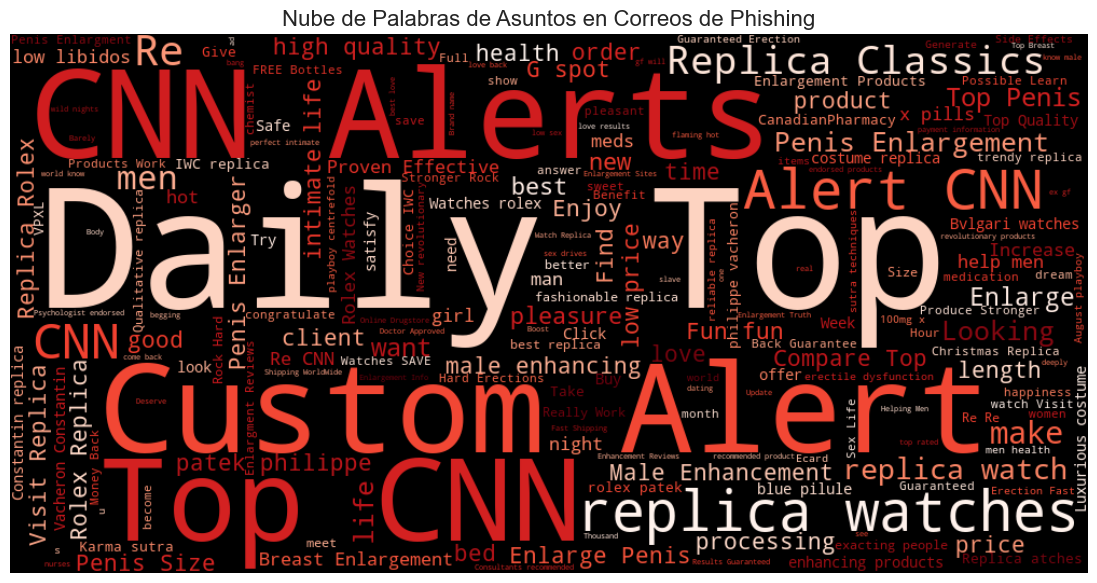

In [7]:
# PASO 4: VISUALIZACIONES
print("\n--- GENERANDO VISUALIZACIONES ---")

# 4.1 Comparación de métricas reales vs proyección de tesis
if not threats_df.empty and (not np.isnan(overall_mttd) and not np.isnan(overall_mttr)):
    metrics = ['MTTD', 'MTTR']
    baseline_values = [overall_mttd, overall_mttr]
    projected_values = [
        overall_mttd * (1 - 0.56),
        overall_mttr * (1 - 0.40)
    ]

    plot_data = pd.DataFrame({
        'Métrica': metrics * 2,
        'Tiempo (Horas)': baseline_values + projected_values,
        'Estado': ['Línea Base'] * 2 + ['Proyectado con Herramienta'] * 2
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Métrica', y='Tiempo (Horas)', hue='Estado', data=plot_data, palette='viridis')
    plt.title('Comparación de Métricas: Línea Base Real vs. Proyección de Tesis', fontsize=16)
    plt.ylabel('Tiempo Promedio (Horas)', fontsize=12)
    plt.xlabel('')
    plt.xticks(fontsize=12)
    plt.legend(title='Estado')
    plt.tight_layout()
    plt.show()

# 4.2 Evolución anual de MTTR y MTTD
if not threats_df.empty and (mttr_by_year is not None or mttd_by_year is not None):
    plt.figure(figsize=(12, 6))
    if mttd_by_year is not None:
        sns.lineplot(x=mttd_by_year.index, y=mttd_by_year.values, marker='o', label='MTTD Promedio (Detección)')
    if mttr_by_year is not None:
        sns.lineplot(x=mttr_by_year.index, y=mttr_by_year.values, marker='o', label='MTTR Promedio (Recuperación)')
    plt.title('Evolución Anual de MTTR y MTTD (2015-2024)', fontsize=16)
    plt.ylabel('Tiempo Promedio (Horas)', fontsize=12)
    plt.xlabel('Año', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4.3 Distribución del MTTR por tipo de amenaza (Boxplot)
if not threats_df.empty and 'Threat_Type' in threats_df.columns and 'Resolution_Time_Hours' in threats_df.columns:
    top_5_threats = threats_df['Threat_Type'].value_counts().nlargest(5).index
    top_threats_df = threats_df[threats_df['Threat_Type'].isin(top_5_threats)]

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Threat_Type', y='Resolution_Time_Hours', data=top_threats_df, palette='plasma')
    plt.title('Distribución del Tiempo de Recuperación (MTTR) por Tipo de Amenaza', fontsize=16)
    plt.ylabel('Tiempo de Recuperación (Horas) - Escala Logarítmica', fontsize=12)
    plt.xlabel('Tipo de Amenaza', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# 4.4 Mapa de calor de frecuencia de incidentes por industria y año
if not threats_df.empty and 'Affected_Industry' in threats_df.columns and 'Year' in threats_df.columns:
    top_10_industries = threats_df['Affected_Industry'].value_counts().nlargest(10).index
    heatmap_df = threats_df[threats_df['Affected_Industry'].isin(top_10_industries)]
    industry_year_crosstab = pd.crosstab(heatmap_df['Affected_Industry'], heatmap_df['Year'])

    plt.figure(figsize=(16, 10))
    sns.heatmap(industry_year_crosstab, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
    plt.title('Mapa de Calor: Frecuencia de Incidentes por Industria y Año (Top 10 Industrias)', fontsize=16)
    plt.ylabel('Industria Afectada', fontsize=12)
    plt.xlabel('Año', fontsize=12)
    plt.tight_layout()
    plt.show()

# 4.5 Nube de palabras de asuntos de phishing
if not phishing_df.empty and 'Actual_Phishing' in phishing_df.columns and 'Subject' in phishing_df.columns:
    phishing_subjects = ' '.join(phishing_df.loc[phishing_df['Actual_Phishing'] == 1, 'Subject'].astype(str))
    if len(phishing_subjects.strip()) > 0:
        wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='Reds').generate(phishing_subjects)
        plt.figure(figsize=(14, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nube de Palabras de Asuntos en Correos de Phishing', fontsize=16)
        plt.show()
    else:
        print("No hay asuntos suficientes para generar la nube de palabras.")
